In [26]:
import os

import scipy.io as sio
from scipy.io import readsav
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import fits
import mpyfit
from tqdm.notebook import tqdm
import scipy.stats
from scipy.stats import median_abs_deviation 
from residual_plot import residual_plot
from Least_sq_fit import Least_sq_fit
from Weighted_LS_fit import Weighted_LS_fit
from Weighted_LS_crossval_fit import Weighted_LS_crossval_fit
from multi_residual_plot import multi_residual_plot
from fwhm_sigma import fwhm_sigma
from std import std

In [27]:
star_name = '26965'#'101501'#34411# '26965', '10700'
sigma_og = int(round(7.368447606251439*2.335,0))
#10700: sigma = 7.383140920635955
#101501: sigma = 7.962301628103782
#34411: sigma = 8.067395257041321, [350, 388, 398, 408, 441]
#26965: sigma = 7.368447606251439
file_end = 'prov_rvs' #"best_fit"#"best_fit" #"prov_rvs"#or 

hdul_open = fits.open('HD'+star_name+'/binned_ccfs/binned_ccfs_'+file_end+'.fits', memmap=False)
wls = hdul_open[1].data['wls']
ccf_list = hdul_open[1].data['binned_ccfs']#[8:]
ccf_list = ccf_list - np.median(ccf_list, axis=0)
median_residual = np.median(ccf_list, axis=0)
std_residual = np.std(ccf_list, axis=0)
rescaled_resids = (ccf_list-median_residual)/std_residual

bjd_list = hdul_open[2].data['bjd']#[8:]

if file_end =="best_fit":
    rv_list = hdul_open[2].data['mu_og_list']
else:
    rv_list = hdul_open[2].data['vrad_star']

#rv_list = hdul_open[2].data['vrad_star']# hdul_open[2].data['mu_og_list'] # [8:] #hdul_open[2].data['mu_og_list'][8:] #
rv_error = hdul_open[2].data['svrad_star']#[8:]

# create pandas dataframe
df = pd.DataFrame(list(zip(bjd_list, rv_list, rv_error, rescaled_resids)), columns=["BJD","vrad", "svrad", "CCF"])
df_sorted = df.sort_values(by=['BJD']) 

7.368337842082745

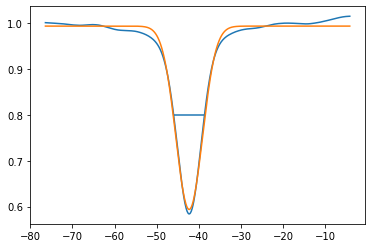

In [25]:
# Finds the local minima using a Gaussian fit
# Define the actual function where     A = p[0], mu = p[1], sigma = p[2], c = p[3]
def gauss(x, p):
        return -p[0] * np.exp(-(x - p[1]) ** 2 / (2. * p[2] ** 2)) + p[3]

# A simple minimization function:
def least(p, args):
        x, y = args
        return gauss(x, p) - y

mu_og_list = []
sigma_og_list = []
std_list = []
fwhm_list = []
for CCF_data in hdul_open[1].data['binned_ccfs'][0:1]:
        plt.plot(wls[0],CCF_data)
    
        m = np.median(CCF_data)
        
        parinfo = [{'fixed': False, 'step': 1e-4*m},
                   {'fixed': False, 'step': 1e-6},
                   {'fixed': False, 'step': 1e-4},
                   {'fixed': False, 'step': 1e-3*m}]
        
        # no_shift fit
        std = fwhm_sigma(m-CCF_data, wls[0])[1]
        std_list.append(std)
        fwhm = fwhm_sigma(m-CCF_data, wls[0])[0]
        fwhm_list.append(fwhm)
        index_mean = np.argmin(CCF_data)
        p0 = [(np.min(CCF_data)-np.max(CCF_data)/np.max(CCF_data))*m,
             wls[0][index_mean],
             std,
             m]
        
        pfit_no_shift, results_no_shift = mpyfit.fit(least, p0, (wls[0], CCF_data), parinfo)
        mu_og = pfit_no_shift[1]
        mu_og_list.append(mu_og)
        sigma_og_list.append(pfit_no_shift[2])
        plt.plot(wls[0],gauss(wls[0],pfit_no_shift))
        
sigma_og_list
sigma_mean = np.mean(sigma_og_list)*2.335
std_mean = np.mean(std_list)*2.335
fwhm_mean = np.mean(fwhm_list)
plt.hlines(0.8, mu_og-sigma_mean/2, mu_og+sigma_mean/2)

sigma_mean

In [28]:
# format data for LS fit
rv_np = np.array(list(df_sorted["vrad"]-np.mean(df_sorted["vrad"])))*1000
s_rv_np = np.array(list(df_sorted["svrad"]))*1000
ccf_list_np = np.array(list(df_sorted["CCF"]))
ccf_list_np_transpose = ccf_list_np.transpose()
time_np = np.array(df_sorted["BJD"])-np.min(df_sorted["BJD"])

[284, 301, 340, 394]

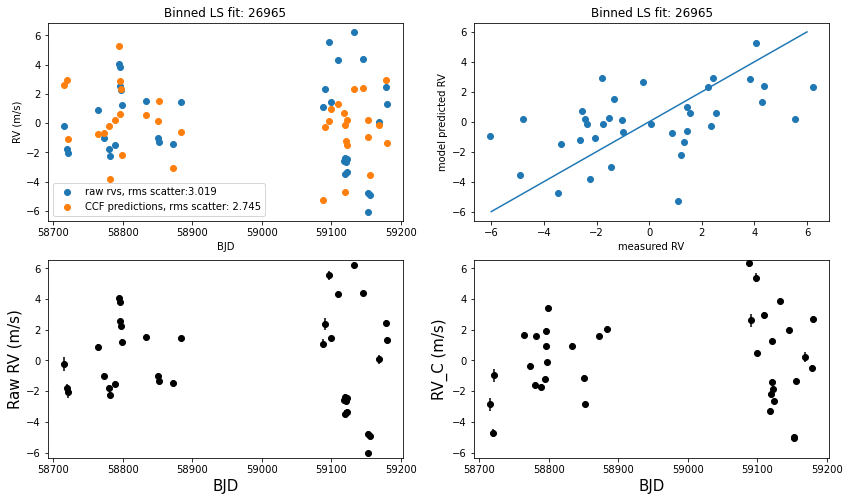

In [41]:
# perform the cross-validation L-S fit on training data --------------
start_index = 320
ccf_indexes =  [284, 284+sigma_og, 340, 394]#[290, 340, 355, 389]#[start_index, start_index+sigma_og, start_index+2*sigma_og, start_index+3*sigma_og]#[352, 305, 325, 367, 406]
#ccf_indexes = np.array(ccf_indexes) -2
# HD 34411: [337, 356, 370, 394]
# HD 10150:  [330, 380, 395, 429]
# HD 26965: [301, 339, 349, 359, 392]
# HD 10700: start_index = 326

y_val_preds_list, raw_val_rms, new_val_rms, new_train_rms_list, a_coeff_list = Weighted_LS_crossval_fit(ccf_indexes, ccf_list_np, rv_np, s_rv_np)
y = rv_np

#plot the results
fig, ax = plt.subplots(2,2, figsize=(14, 8))
ax[0][0].scatter(time_np+np.min(df_sorted["BJD"]),
              y, label="raw rvs, rms scatter:"+str(round(raw_val_rms,3)))
ax[0][0].scatter(time_np+np.min(df_sorted["BJD"]),
              y_val_preds_list, label="CCF predictions, rms scatter: "+str(round(new_val_rms,3)))
ax[0][0].set_ylabel("RV (m/s)")
ax[0][0].set_xlabel("BJD")
ax[0][0].set_title("Binned LS fit: "+star_name)
ax[0][0].legend()

ax[0][1].scatter(y, y_val_preds_list)
ax[0][1].plot([-6,6],[-6,6])
ax[0][1].set_xlabel("measured RV")
ax[0][1].set_ylabel("model predicted RV")
ax[0][1].set_title("Binned LS fit: "+star_name)

# cleaned data plot

#fig, ax1 = plt.subplots(1,2, figsize=(14, 4))

#ax[0].scatter(txt_file["BJD_UTC"]-2400000, txt_file["vrad"]-np.mean(txt_file["vrad"]))
ax[1][0].errorbar(bjd_list, y, yerr = s_rv_np, fmt = 'o', color='k')
ax[1][0].set_xlabel("BJD", size=15)
ax[1][0].set_ylabel("Raw RV (m/s)",size=15)
ax[1][0].set_ylim(np.min(y)-0.3,np.max(y)+0.3)

ax[1][1].errorbar(bjd_list, y-y_val_preds_list, yerr = s_rv_np, fmt = 'o', color='k')
ax[1][1].set_xlabel("BJD", size=15)
ax[1][1].set_ylabel("RV_C (m/s)",size=15)
ax[1][1].set_ylim(np.min(y)-0.3,np.max(y)+0.3)

ccf_indexes

In [42]:
print(np.std(y))
np.std(y-y_val_preds_list)

2.9782336154221833


2.707964128734632

0.0 1.0


[284, 301, 340, 394]

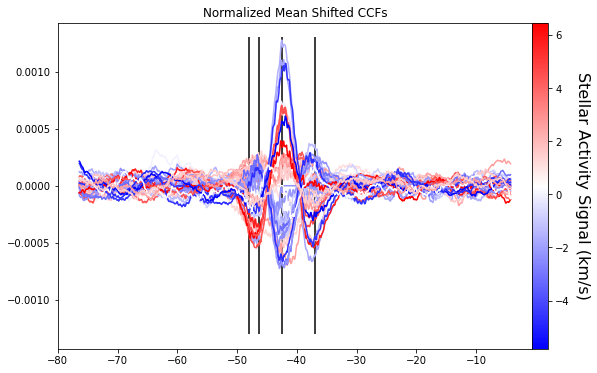

In [43]:
#ccf_indexes = np.array([330, 380, 395, 429])-40

residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")
plt.vlines(wls[0][ccf_indexes], ymin=-0.0013, ymax=0.0013, color="k")

ccf_indexes

In [44]:
nan_array = np.empty((1,len(df_sorted["BJD"])))
nan_array[:] = np.NaN
nan_array[0]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [312]:
# create dataframe to write results to a csv

df_results = pd.DataFrame(list(zip(df_sorted["BJD"], 
                                   y-y_val_preds_list,nan_array[0], 
                                   y_val_preds_list, nan_array[0])),
                        columns=["Time [MJD]",
                                 "RV_C [m/s]","e_RV_C [m/s]",
                                 "RV_A [m/s]","e_RV_A [m/s]"])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/'+'ML_EPRVs_results'):
    os.makedirs('HD'+star_name+'/'+'ML_EPRVs_results')

if file_end == 'prov_rvs':
    full_ending = file_end+'cbc_rvs_results'
else:
    full_ending = file_end+'gaussian_fit_rvs_results'
    


# write results to a file 
df_results.to_csv('HD'+star_name+'/'+'ML_EPRVs_results/binned_'+star_name+"_ML_EPRVs_CCFLinearRegression_"+full_ending+'.csv', index=False)

In [313]:
a_coeff, y_preds, CCF_matrix, raw_rms, ccf_corr_rms = Weighted_LS_fit(ccf_indexes, ccf_list_np, 
                                                     ccf_list_np_transpose,rv_np, s_rv_np)

# create pandas dataframe to write coeff solution to csv
df_coeff = pd.DataFrame(list(zip([ccf_indexes], [a_coeff], [star_name], [raw_rms], [ccf_corr_rms])),
                        columns=["ccf_indexes","a_coeff", "star name", "raw_rms", "ccf_corr_rms"])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/'+'binned_coeffs'):
    os.makedirs('HD'+star_name+'/'+'binned_coeffs')

# write results to a file 
df_coeff.to_csv('HD'+star_name+'/'+'binned_coeffs/coeff'+star_name+"_"+file_end+'.csv', index=False)

In [314]:
# Check file contents
print(file_end)
pd_read= pd.read_csv('HD'+star_name+'/'+'ML_EPRVs_results/binned_'+star_name+"_ML_EPRVs_CCFLinearRegression_"+full_ending+'.csv') 
pd_read

prov_rvs


,Time [MJD],RV_C [m/s],e_RV_C [m/s],RV_A [m/s],e_RV_A [m/s]
0,58764.480469,2.764580,NaN,0.451341,NaN
1,58771.417969,-1.093529,NaN,-0.268186,NaN
2,58772.472656,1.365614,NaN,-0.209629,NaN
3,58773.457031,1.325334,NaN,-0.329566,NaN
4,58778.429688,-0.750248,NaN,-0.138445,NaN
5,58780.402344,-0.291240,NaN,-0.101543,NaN
6,58781.449219,1.547861,NaN,-0.483428,NaN
7,58785.433594,0.886252,NaN,-1.385846,NaN
8,58788.464844,-0.484312,NaN,-0.076317,NaN
9,58794.425781,0.434830,NaN,-0.346960,NaN


In [315]:
print(np.std(pd_read['RV_C [m/s]']+pd_read['RV_A [m/s]']))#,ddof=1))
print(np.std(pd_read['RV_C [m/s]']))#,ddof=1))


1.5047152887444488
1.3987407720955933


In [5]:
# define functions for mcmc

jitterpar = 0


def log_likelihood(theta, t, x, y, e):
    D, a0, a1, a2, a3, a4  = theta
    model = D*x[:,0] + a0*x[:,1] + a1*x[:,2] + a2*x[:,3] + a3*x[:,4] + a4*x[:,5]# +a5*x[:,5] + a6*x[:,6] + a7*x[:,7] +a8*x[:,8]
    sigma2 = e**2 + jitterpar**2
    loglikelihood =  -0.5 * np.sum((y - model) ** 2 / sigma2 )#+ np.log(sigma2))
    return loglikelihood

def log_prior(theta):
    D ,  a0, a1, a2, a3, a4 = theta
    #jitterpar, D , a0, a1, a2, a3, a4 = theta
    #amplitude, jitterpar, D, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = theta
    #if 0.01 < jitterpar < 4.0:
    #    return 0.0
    if 0.1 < D < 5:
        return 0.0
    return -np.inf

def log_probability(theta, t, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, x, y, yerr)

y_val_mcmc_preds = []

# Loop through cross-validation sets 
for i in range(0, len(rv_np)):
    train_rv_np = np.delete(rv_np, i)
    train_s_rv_np = np.delete(s_rv_np,i)
    train_ccf_list_np = np.delete(ccf_list_np, i, 0)
    train_ccf_list_np_transpose = train_ccf_list_np.transpose()
    train_time_np = np.delete(time_np,i)
    
    n_cols = len(ccf_indexes) + 1
    n_rows = len(train_ccf_list_np)  # len(ccf_list_np)<---- unsmoothed
    x_train = np.zeros((n_rows, n_cols))
    x_train[:, 0] = 1
    for i in np.arange(0, len(ccf_indexes)):
        x_train[:, i + 1] = ccf_list_np_transpose[ccf_indexes[i]] 
    
    val_rv_np = rv_np[i]
    val_s_rv_np = s_rv_np[i]
    val_ccf_list_np = ccf_list_np[i]
    val_ccf_list_np_transpose = np.array([val_ccf_list_np]).transpose()
    train_time_np = time_np[i]
    n_rows = len(val_ccf_list_np)  # len(ccf_list_np)<---- unsmoothed
    x_val = np.zeros((n_rows, n_cols))
    x_val[:, 0] = 1
    for i in np.arange(0, len(ccf_indexes)):
        x_val[:, i + 1] = val_ccf_list_np_transpose[ccf_indexes[i]] 
    
    #double checks if the validation example is excluded from the training set
    if val_rv_np in train_rv_np:
        print("val rv example is in training set!")
    if val_s_rv_np in train_s_rv_np:
        print("val s_rv example is in training set!")
    if any(x in val_ccf_list_np.tolist() for x in [list(ccf_list_np[i])]):
        print("val ccf example is in training set!")
    
    solnx = a_coeff_list[i]
    
    #mcmc
    pos = solnx + 1e-4 * np.random.randn(60, len(solnx)) #ball size array for each parameter
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                    args=(train_time_np, x_train, train_rv_np, train_s_rv_np))
    sampler.run_mcmc(pos, 5000, progress=True)
    
    # discard first 100 burn-in samples
    flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)
    
    All_mcmc_coeffs = np.zeros(len(a_coeff))
    for i in np.arange(0, len(a_coeff)):
        All_mcmc_coeffs[i]=  np.percentile(flat_samples[:, i], [50])[0]
    
    y_preds = x_val.dot(All_mcmc_coeffs)
    y_val_mcmc_preds.append(y_preds)
        
# make this part of of for loop
solnx = a_coeff_list[0]

ValueError: could not broadcast input array from shape (34) into shape (33)